# Выпускной проект: телекоммуникации


**План проекта:**

[Описание](#1)

[Импорт библиотек](#2)

[Установка констант](#3)


**[1. Предобработка данных](#4)**

[Загрузка датасета](#5)

[Преобразование наименований столбцов](#6)

[Преобразование типов данных](#7)

[Заполнение пропусков](#25)

[Конвертация бинарных признаков](#26)

[Обработка дубликатов](#8)

[Обработка неявных дубликатов](#9)

[Промежуточный вывод](#27)

**[2. Исследовательский анализ данных](#10)**

[Создание объединенного датафрема](#11)

[Добавление новых признаков](#12)

[Матрица корреляции Фk](#13)

[Визуализация числовых признаков](#14)

[Визуализация категориальных признаков](#15)

[Промежуточный вывод](#28)

**[3. Подготовка данных](#16)**

**[4. Обучение моделей машинного обучения](#17)**

**[5. Выбор лучшей модели и ее тестирование](#18)**

[Результат кросс-валидации](#19)

[Тестирование](#20)

[ROC-анализ](#21)

[Анализ важности признаков](#22)

[Матрица ошибок и подбор порога](#23)

**[6. Общий вывод и рекомендации заказчику](#24)**


<a id="1"></a>
**Описание**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Файл - `contract_new.csv`
- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

Файл - `personal_new.csv`
- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

Файл - `internet_new.csv`
- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

Файл `phone_new.csv`
- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

<a id="2"></a>
**Импорт библиотек**

In [1]:
#!pip install lightgbm -q
#!pip install catboost -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import os
import phik
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import (
    recall_score, 
    precision_score, 
    confusion_matrix, 
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc
)


<a id="3"></a>
**Установка констант**

In [5]:
RANDOM_STATE = 100325
TEST_SIZE=0.25

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

<a id="4"></a>
## Предобработка данных


<a id="5"></a>
### Загрузка

In [7]:
pth1 = f'/datasets/contract_new.csv'
pth2 = f'C:/Датафреймы python/contract_new.csv'

if os.path.exists(pth1):
    contract = pd.read_csv(pth1)
elif os.path.exists(pth2):
    contract  = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(contract.head(2))
display(contract.tail(2))
contract.info()    


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.8
7042,3186-AJIEK,2014-08-01,No,Two year,Yes,Bank transfer (automatic),105.65,7251.82


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [8]:
pth1 = f'/datasets/personal_new.csv'
pth2 = f'C:/Датафреймы python/personal_new.csv'

if os.path.exists(pth1):
    personal = pd.read_csv(pth1)
elif os.path.exists(pth2):
    personal  = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(personal.head(2))
display(personal.tail(2))
personal.info()    


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [9]:
pth1 = f'/datasets/internet_new.csv'
pth2 = f'C:/Датафреймы python/internet_new.csv'

if os.path.exists(pth1):
    internet = pd.read_csv(pth1)
elif os.path.exists(pth2):
    internet  = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(internet.head(2))
display(internet.tail(2))
internet.info()    


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No
5516,3186-AJIEK,Fiber optic,Yes,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [10]:
pth1 = f'/datasets/phone_new.csv'
pth2 = f'C:/Датафреймы python/phone_new.csv'

if os.path.exists(pth1):
    phone = pd.read_csv(pth1)
elif os.path.exists(pth2):
    phone  = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
display(phone.head(2))
display(phone.tail(2))
phone.info()    


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No


,customerID,MultipleLines
6359,8361-LTMKD,Yes
6360,3186-AJIEK,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


<a id="6"></a>
### Преобразование наименований столбцов

In [9]:
def rename_col(df):
    
    rename_dict = {}

    for col in df.columns:    

        j = []
        h = []

        for i, n in enumerate(col):
            if i> 0 and n.isupper() == True:
                j.append(i)
                h.append(n)
        
        if len(j) == 1  or (len(j) == 2 and j[1]-j[0]==1): 
            col_name = (col[:j[0]] + '_' + h[0] + col[j[0]+1:]).lower()

        elif len(j) == 2:
            col_name = (col[:j[0]] + '_' + h[0] + col[j[0]+1:j[1]] + '_' + h[1] + col[j[1]+1:]).lower()

        else:
            col_name = col.lower()

        rename_dict[col] = col_name
        
    return df.rename(columns=rename_dict)
    

In [10]:
contract = rename_col(contract)
personal = rename_col(personal)
internet = rename_col(internet)
phone = rename_col(phone)

In [11]:
for n in [contract, personal, internet, phone]:
    print(n.columns)


Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['customer_id', 'multiple_lines'], dtype='object')


<a id="7"></a>
### Преобразование типов данных

Преобразуем тип данных в столбцах 'begin_date' и 'end_date' в формат даты.

In [12]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%d')


<a id="25"></a>
### Заполнение пропусков

Для действующих договоров заполним дату окончания контракта, равную датой выгрузки - '2020-02-01'

In [13]:
contract.loc[(contract['end_date'] == 'No'), 'end_date'] = '2020-02-01'
contract['end_date'] = pd.to_datetime(contract['end_date'], format='%Y-%m-%d')

In [14]:
contract['total_charges'].min()


' '

In [15]:
contract.loc[(contract['total_charges'] == ' ')] 


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,


Для новых договоров, заключенных в феврале, оплата еще не отображена, заполним 0.

In [16]:
contract.loc[(contract['total_charges'] == ' '), 'total_charges'] = 0

In [17]:
contract['total_charges'] = \
contract['total_charges'].astype('float64')

<a id="26"></a>
### Конвертация бинарных признаков

Конвертируем бинарные признаки 'yes/no' в '1/0'.

In [18]:
contract['paperless_billing'] = \
contract['paperless_billing'].apply(lambda x: 1 if x == 'Yes' else 0)

In [19]:
personal[['partner', 'dependents']] = \
personal[['partner', 'dependents']].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

In [20]:
internet[['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']] = \
(internet[['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']]
 .apply(lambda x: x.map({'Yes': 1, 'No': 0})))

In [21]:
phone['multiple_lines'] = \
phone['multiple_lines'].apply(lambda x: 1 if x == 'Yes' else 0)

In [22]:
for n in [contract, personal, internet, phone]:
    display(n.dtypes)

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing             int64
payment_method               object
monthly_charges             float64
total_charges               float64
dtype: object

customer_id       object
gender            object
senior_citizen     int64
partner            int64
dependents         int64
dtype: object

customer_id          object
internet_service     object
online_security       int64
online_backup         int64
device_protection     int64
tech_support          int64
streaming_tv          int64
streaming_movies      int64
dtype: object

customer_id       object
multiple_lines     int64
dtype: object

<a id="8"></a>
### Обработка дубликатов

In [23]:
for n in [contract, personal, internet, phone]:
    display(f'Кол-во дубликатов {n.duplicated().sum()}')

'Кол-во дубликатов 0'

'Кол-во дубликатов 0'

'Кол-во дубликатов 0'

'Кол-во дубликатов 0'

<a id="9"></a>
### Обработка неявных дубликатов

In [24]:
def func(list_col, data):
    for col_l in list_col:
        print('-'* 50)
        print(col_l, data[col_l].sort_values().unique())    

print('dataframe: contract')
func(['type','payment_method'], contract)
print('')

print('dataframe: personal')
func(['gender'], personal)
print('')

print('dataframe: internet')
func(['internet_service'], internet)
print('')

dataframe: contract
--------------------------------------------------
type ['Month-to-month' 'One year' 'Two year']
--------------------------------------------------
payment_method ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']

dataframe: personal
--------------------------------------------------
gender ['Female' 'Male']

dataframe: internet
--------------------------------------------------
internet_service ['DSL' 'Fiber optic']



<a id="27"></a>
### Промежуточный вывод


- После записи датасета в одноименные переменные contract, personal, internet, phone и первичного знакомства с данными видим, что данные в таблицах соответствуют описанию.
- Наименования столбцов в датафреймах приведены к "змеиному" регистру.
- Колонки с информацией о дате открытия и закрытия договоров, приведены к формату даты.
- Для действующих договоров в колонке "end_date" заполнена дата окончания контракта, равная дате выгрузки - '2020-02-01'.
- Для новых договоров, заключенных в феврале, в "total_charges" записан 0.
- Бинарные категориальные признаки конвертированы в '1/0'.
- Данные не содержат дубликаты.
- Датафреймы `personal` и `contract` содержат одинаковое количество строк - 7043.
- Датафреймы `internet` и `phone` имеют отличное число строк - 5517 и 6361 соотвественно.


<a id="10"></a>
## Исследовательский анализ данных

<a id="11"></a>
### Создание объединенного датафрема

In [25]:
data = (contract.set_index('customer_id')
        .join(personal.set_index('customer_id'))
        .join(internet.set_index('customer_id'))
        .join(phone.set_index('customer_id'))).reset_index()

display(data.head(3))

data.isna().sum()


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,31.04,Female,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,2071.84,Male,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,1,Mailed check,53.85,226.17,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0


customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Заполним пропуски в объединенном датафрейме значениями, отображающими отсутствие подключенных услуг у абонентов.

In [26]:
data.loc[(data['internet_service'].isna()), 'internet_service'] = 'No'

data.loc[(data['online_security'].isna()), 
         ['online_security',
           'online_backup',
           'device_protection',
           'tech_support',
           'streaming_tv',
           'streaming_movies']] = 0

data.loc[(data['multiple_lines'].isna()), 'multiple_lines'] = 0

data.isna().sum()


customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

<a id="12"></a>
### Добавление новых признаков

Добавим новые признаки:
- целевой признак `churn`:
    - 1 - клиент закрыл договор и попал в отток.
    - 0 - клиент действующий.
- длительность подписки в днях - `sub_duration`.
- количество интернет услуг - `num_services`.

In [27]:
data['churn'] = \
data['end_date'].apply(lambda x: 1 if x < pd.to_datetime('2020-02-01') else 0)

In [28]:
data['sub_duration'] = (data['end_date'] - data['begin_date']).dt.days


In [29]:
data['num_services'] = (data['online_security'] 
                        + data['online_backup'] 
                        + data['device_protection'] 
                        + data['tech_support']
                        + data['streaming_tv']
                        + data['streaming_movies'])
                               

In [30]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
display(data.head(3))


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,churn,sub_duration,num_services
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,1,Electronic check,29.85,31.04,Female,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,31,1.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,0,Mailed check,56.95,2071.84,Male,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1036,2.0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,1,Mailed check,53.85,226.17,Male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,123,2.0


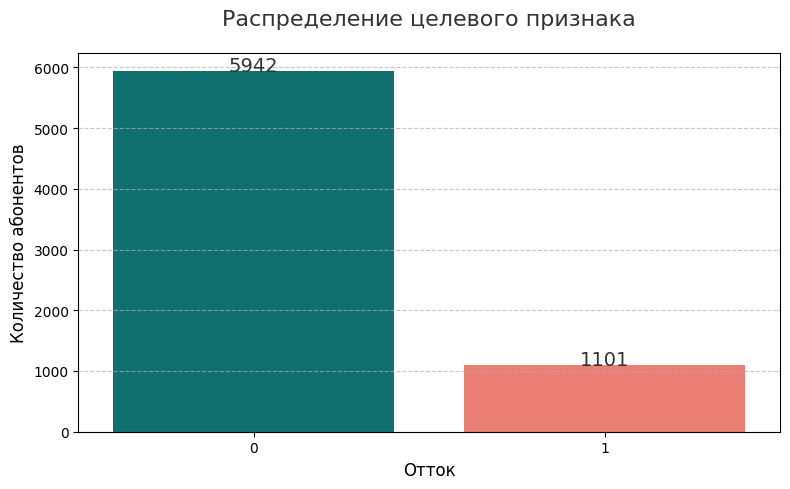

In [31]:
zeros = len(data['churn']) - data['churn'].sum()  
ones = data['churn'].sum()    

categories = ['0', '1']
counts = [zeros, ones]

plt.figure(figsize=(8, 5))
sns.barplot(x=categories, y=counts, palette=['#008080', '#FF6F61'])
plt.title('Распределение целевого признака', fontsize=16, pad=20, color='#333333')
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Количество абонентов', fontsize=12)

for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', fontsize=14, color='#333333')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

<a id="13"></a>
### Матрица корреляции Фk

In [32]:
def draw_phik_matrix(dataframe, type_value):

    df_corr = (dataframe.drop(['customer_id',
                               'begin_date', 
                               'end_date', 
                               'online_security',
                               'online_backup',
                               'device_protection',
                               'tech_support',
                               'streaming_movies',
                               'streaming_tv'
                               
                              ], axis=1)
    .phik_matrix(interval_cols=dataframe
                 .select_dtypes(include='number')
                 .columns.tolist()))

    plot_correlation_matrix(
        df_corr.values,
        x_labels=df_corr.columns,
        y_labels=df_corr.index,
        vmin=0, vmax=1, color_map='Greens',
        title=r'correlation $\phi_K$'+ type_value,
        fontsize_factor=1.2,
        figsize=(15, 7)
    ) 
    


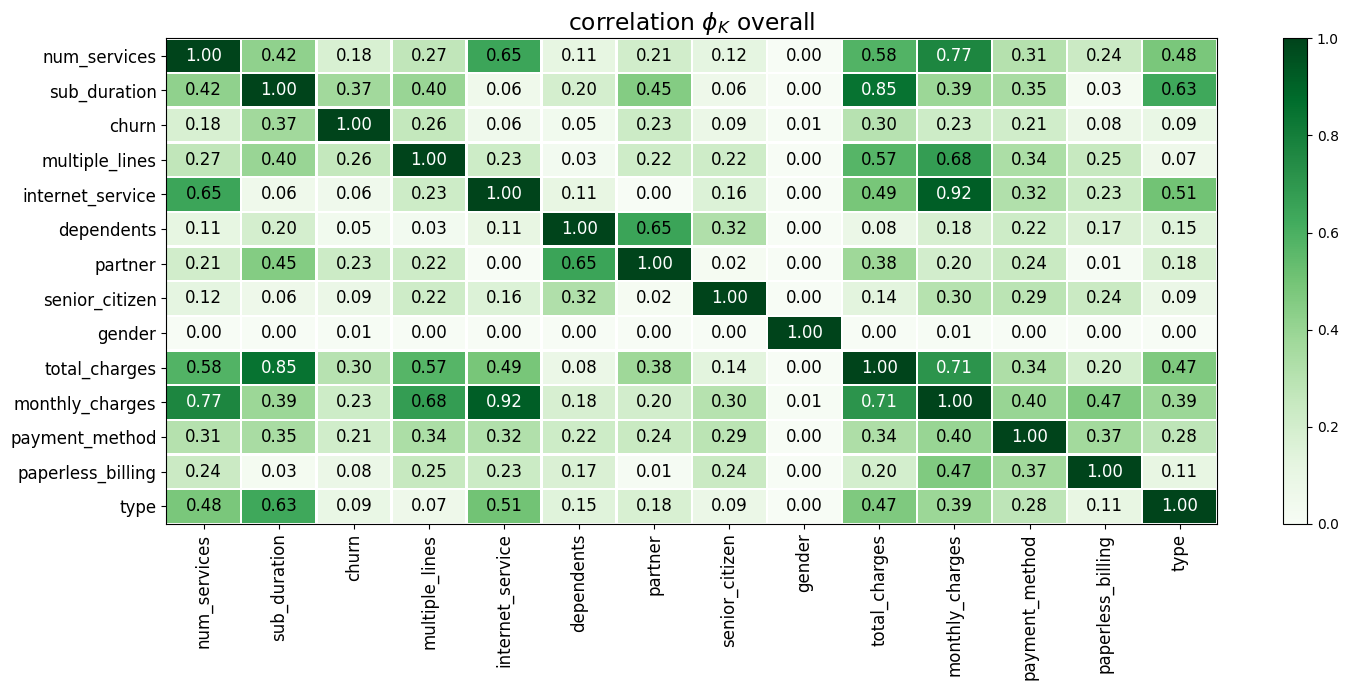

In [33]:
draw_phik_matrix(data,' overall')

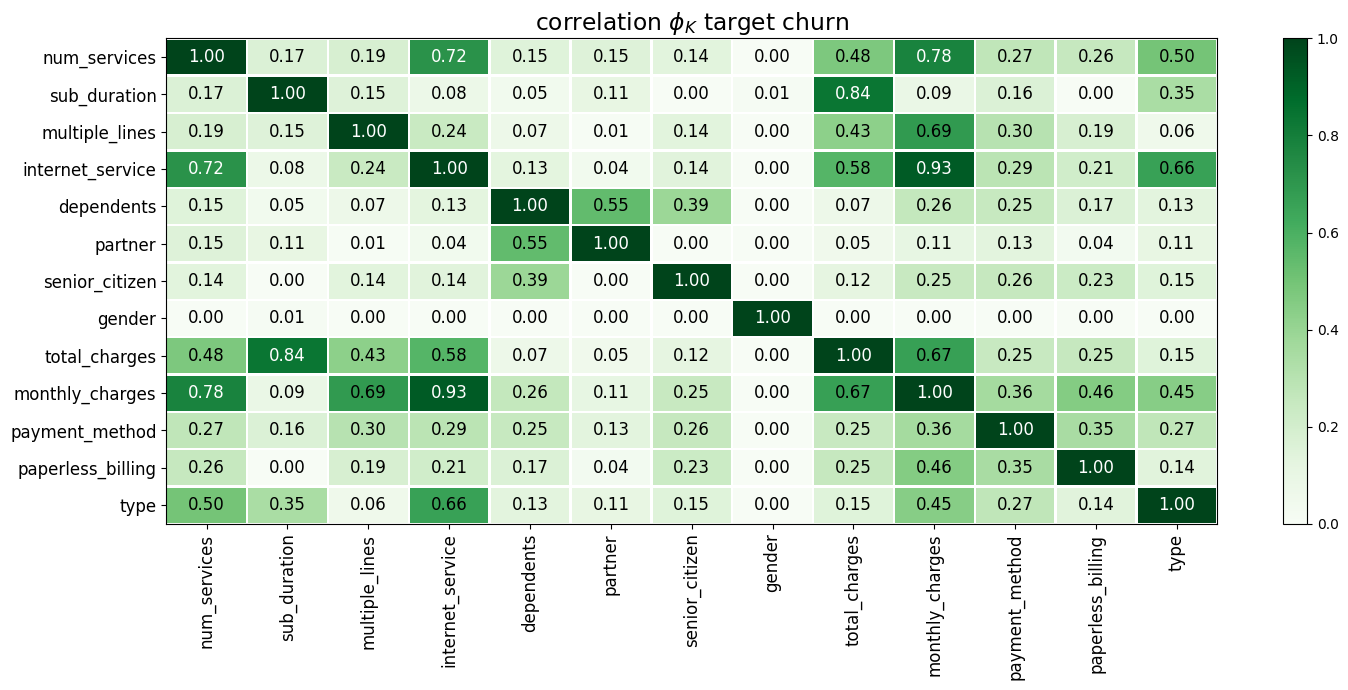

In [34]:
draw_phik_matrix(data.query('churn == 1').drop('churn', axis=1),' target churn')

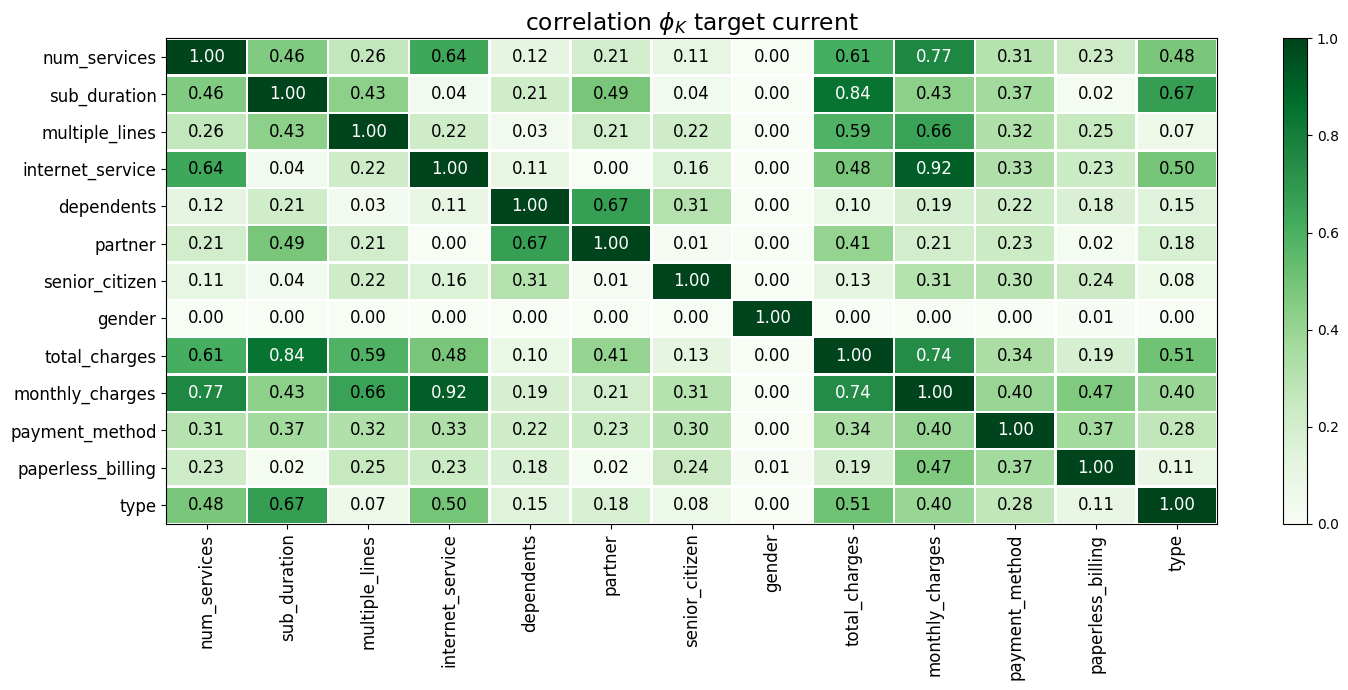

In [35]:
draw_phik_matrix(data.query('churn == 0').drop('churn', axis=1),' target current')

<a id="14"></a>
### Визуализация числовых признаков

In [36]:
sns.set_style("whitegrid")
plt.style.use('seaborn')


def draw_number_chart(dataframe):

    for i, col in enumerate(dataframe[dataframe.select_dtypes(include='number').columns.tolist()]):

        x_label = ('Сумма' if col in ['monthly_charges'] 
             else 'Сумма' if col in ['total_charges']
             else 'Дни' if col in ['sub_duration']                
                   else 'Количество') 
        title_name = col[0].upper() + col[1:].lower()

        mean_value = dataframe[col].mean()
        median_value = dataframe[col].median()

        plt.figure(i)
        

        fig, axs = plt.subplots(nrows = 1 , ncols = 2, figsize = (10,3))

        sns.histplot(data = dataframe, x = dataframe[col], ax=axs[0], kde=True, bins = 30, legend=True);
        axs[0].axvline(mean_value, linewidth=2, color='orange', alpha=1, linestyle='--', label = 'Среднее = {:.3f}'.format(mean_value))
        axs[0].axvline(median_value, linewidth=2, color='orange', alpha=1, linestyle='-', label = 'Медиана = {:.3f}'.format(median_value))
        axs[0].set_xlabel(x_label)
        axs[0].set_ylabel('Кол-во клиентов')
        axs[0].legend(fontsize="8")

        sns.boxplot(data = dataframe, x = dataframe[col], ax=axs[1]);
        axs[1].set_xlabel(x_label)
        fig.suptitle(title_name)    
    

<Figure size 800x550 with 0 Axes>

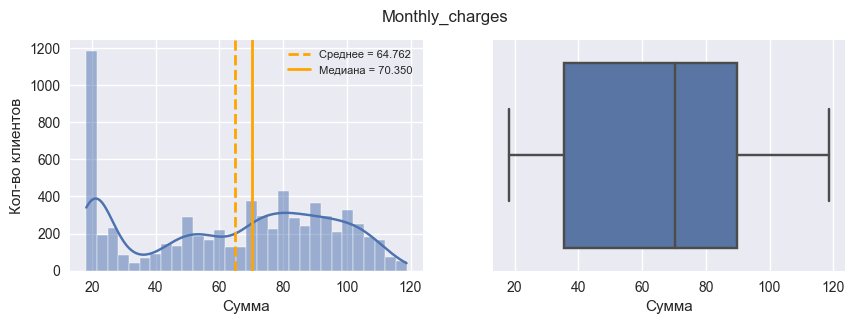

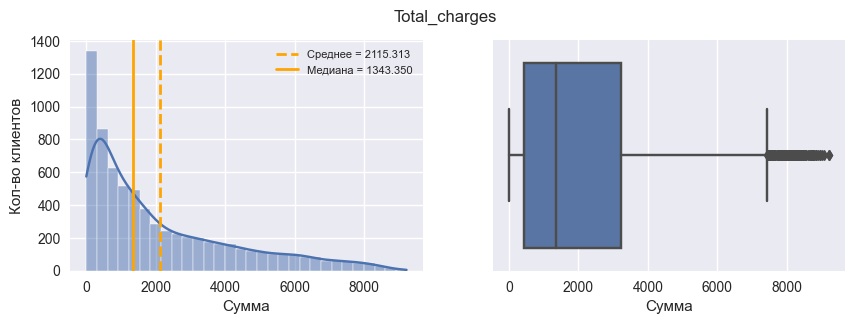

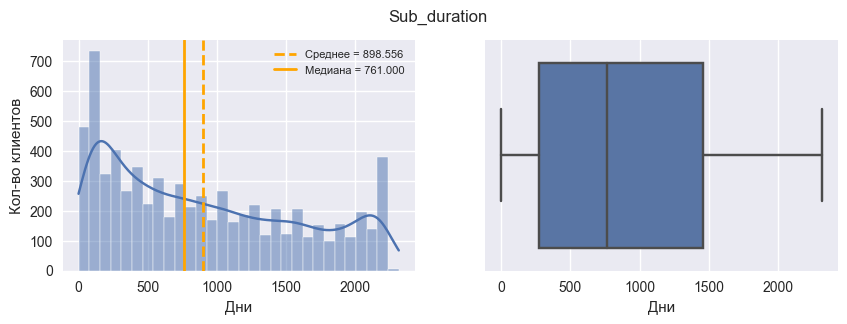

In [37]:
draw_number_chart(data[['monthly_charges','total_charges','sub_duration']])

<Figure size 1500x500 with 0 Axes>

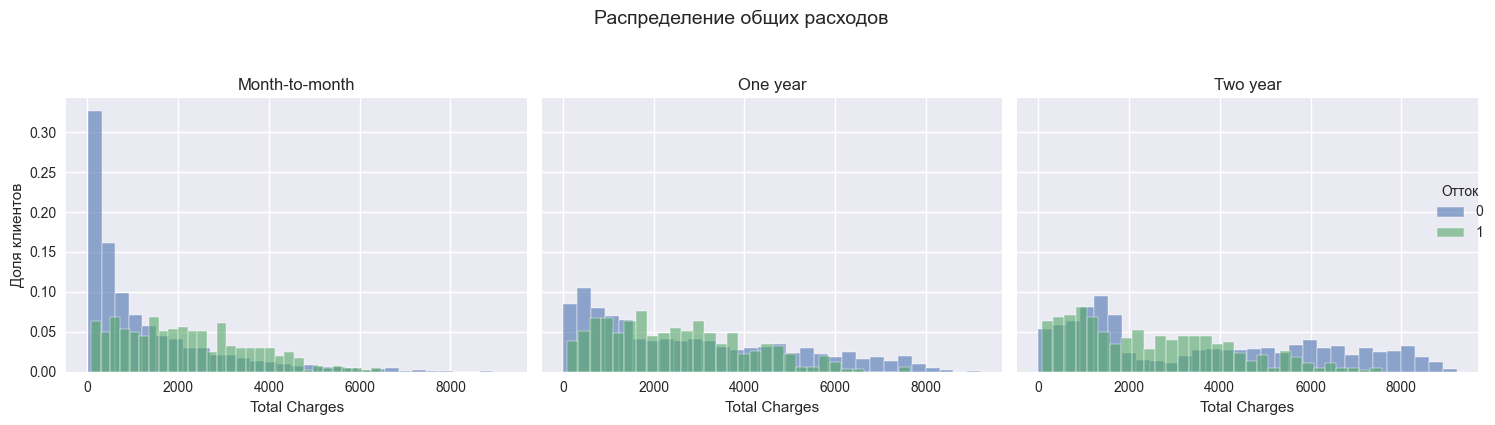

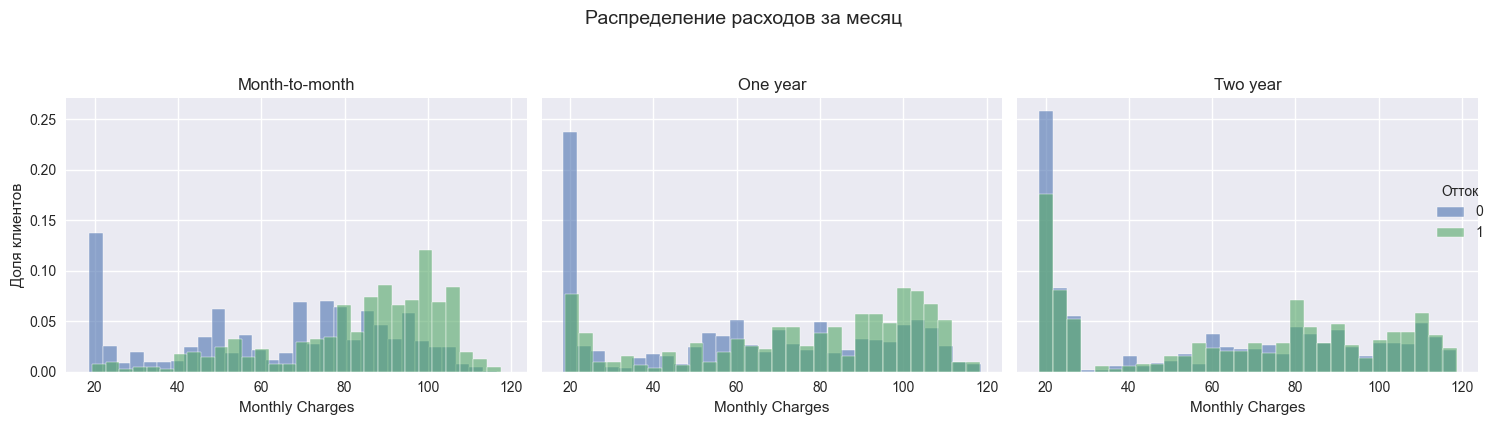

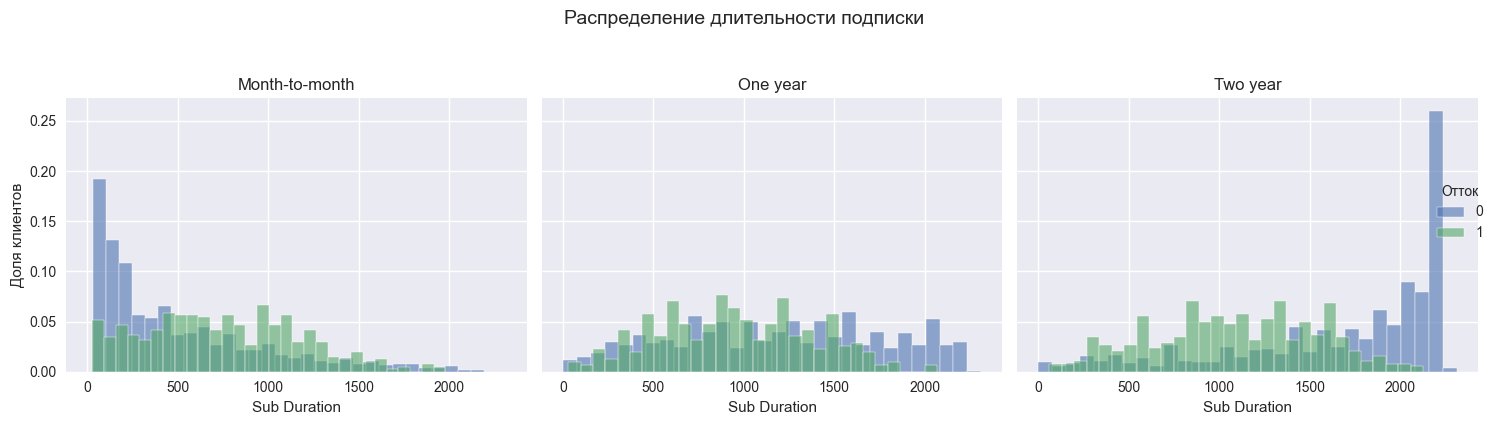

In [38]:
cols = ['total_charges', 'monthly_charges', 'sub_duration']

fig = plt.figure(figsize=(15, 5)) 

for i, col in enumerate(cols, 1):
    g = sns.FacetGrid(data, col='type', hue='churn', height=4, aspect=1.2)
    g.map(sns.histplot, col, stat='probability', bins=30, alpha=0.6)
    
    g.set_titles(col_template="{col_name}", size=12)
    g.add_legend(title='Отток')
    g.set_axis_labels(f"{col.replace('_', ' ').title()}", "Доля клиентов")
    
    title_name = ('общих расходов ' if col in ['total_charges']
                      else 'расходов за месяц' if col in ['monthly_charges'] 
                      else 'длительности подписки' if col in ['sub_duration'] 
                      else col[0].upper() + col[1:].lower())   
    
    g.fig.suptitle(f"Распределение {title_name}", 
                   y=1.05, 
                   fontsize=14)
    
    plt.tight_layout()

plt.show()

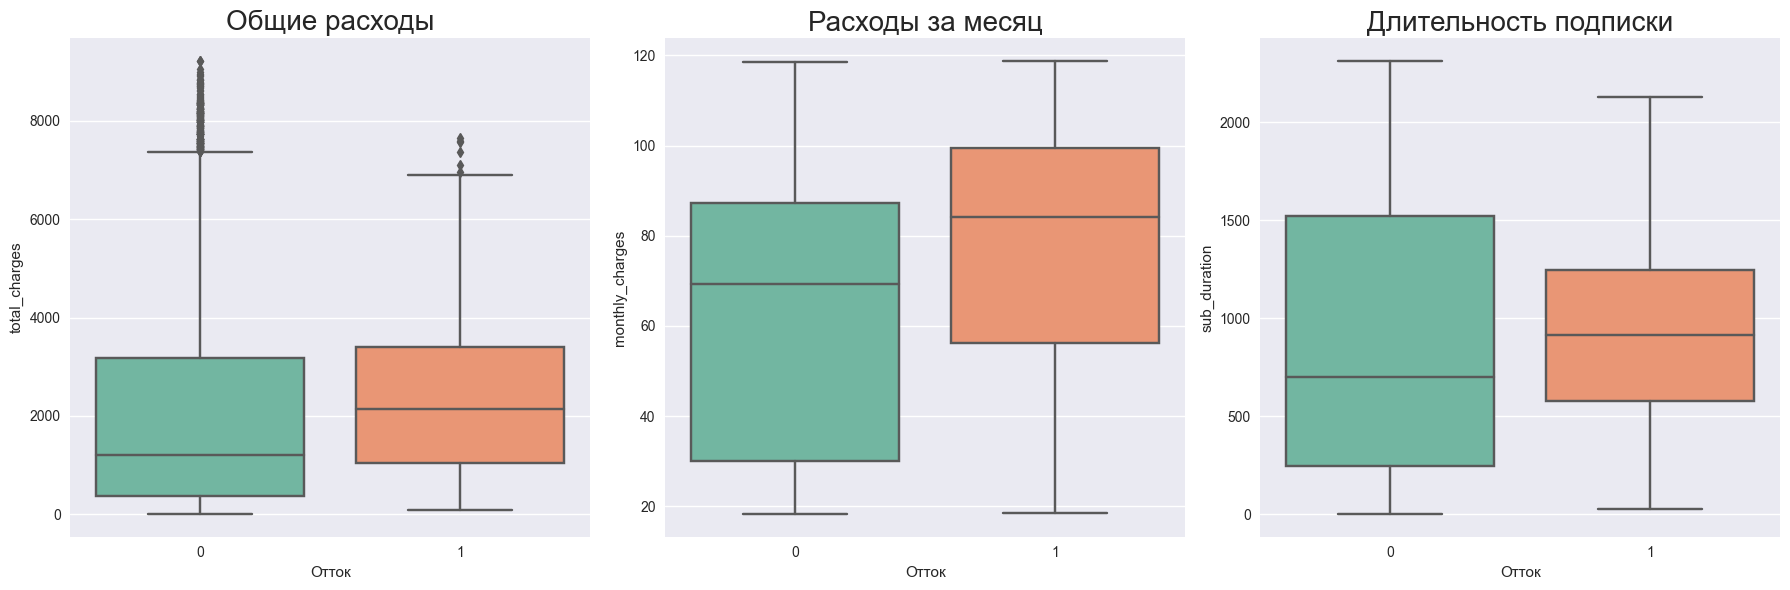

In [39]:
columns = ['total_charges', 'monthly_charges', 'sub_duration']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, col in enumerate(columns):  
   
    sns.boxplot(x='churn', y=col, data=data, ax=axes[i], palette="Set2")
    
    title_name = ('Общие расходы' if col == 'total_charges'
                  else 'Расходы за месяц' if col == 'monthly_charges'
                  else 'Длительность подписки')   
    
    axes[i].set_title(title_name, fontsize=20) 
    axes[i].set_xlabel('Отток')

plt.tight_layout()
plt.show()

<a id="15"></a>
### Визуализация категориальных признаков

In [40]:
def draw_categorical_chart(df1):
    for i, col in enumerate(df1.drop(['customer_id', 'churn'], axis=1)):
        plt.figure(i)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6)) 

        title_name = col[0].upper() + col[1:].lower()    
        
        dataframe = df1.groupby(col).agg(prop=(col, 'count'))
        axes[0].pie(dataframe['prop'], autopct='%1.0f%%', textprops={'fontsize': 11})

        axes[0].set_title(title_name if len(title_name) < 30 
                          else (f'{title_name[0: title_name[0:int(len(title_name)*0.6)].rfind(" ")]}\
                          \n{title_name[title_name[0:int(len(title_name)*0.6)].rfind(" "):]}'), 
                          fontsize=16)
        
        unique_values = dataframe.reset_index()[col].unique()
        legend_labels = ['Yes' if val == 1 and col != 'num_services' 
                         else 'No' if val == 0 and col != 'num_services' 
                         else val for val in unique_values]  

        axes[0].legend(legend_labels,
                      loc='center left',
                      bbox_to_anchor=(1, 0.5),
                      fontsize=12,
                      bbox_transform=axes[0].transAxes)

        (
            pd.pivot_table(df1, index=col, columns='churn', values='customer_id', aggfunc='count')
            .apply(lambda x: x*100/sum(x), axis=1)
            .plot(kind="bar", stacked=True, ax=axes[1], xlabel=title_name, ylabel='%')
        )
        axes[1].set_title(f'Соотношение ушедших и действующих клиентов \n в зависимости от {col}')

        plt.tight_layout(pad=3.0)  
    plt.show()

<Figure size 800x550 with 0 Axes>

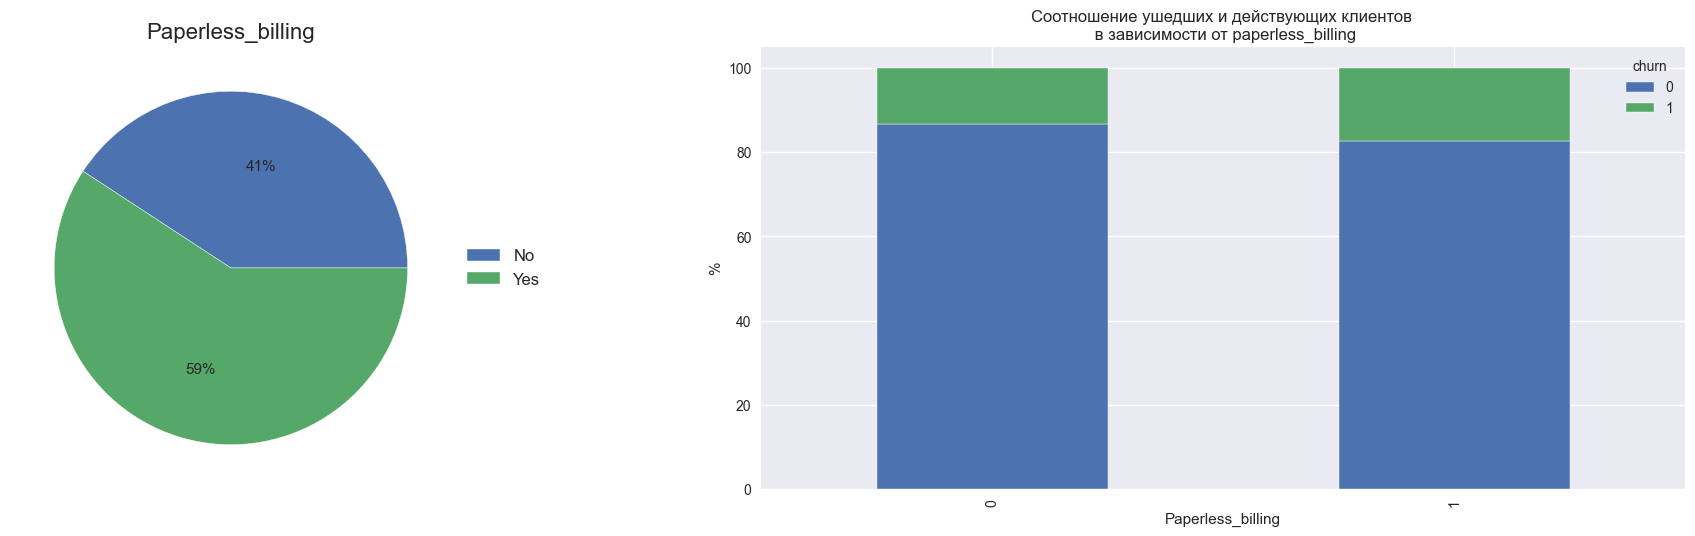

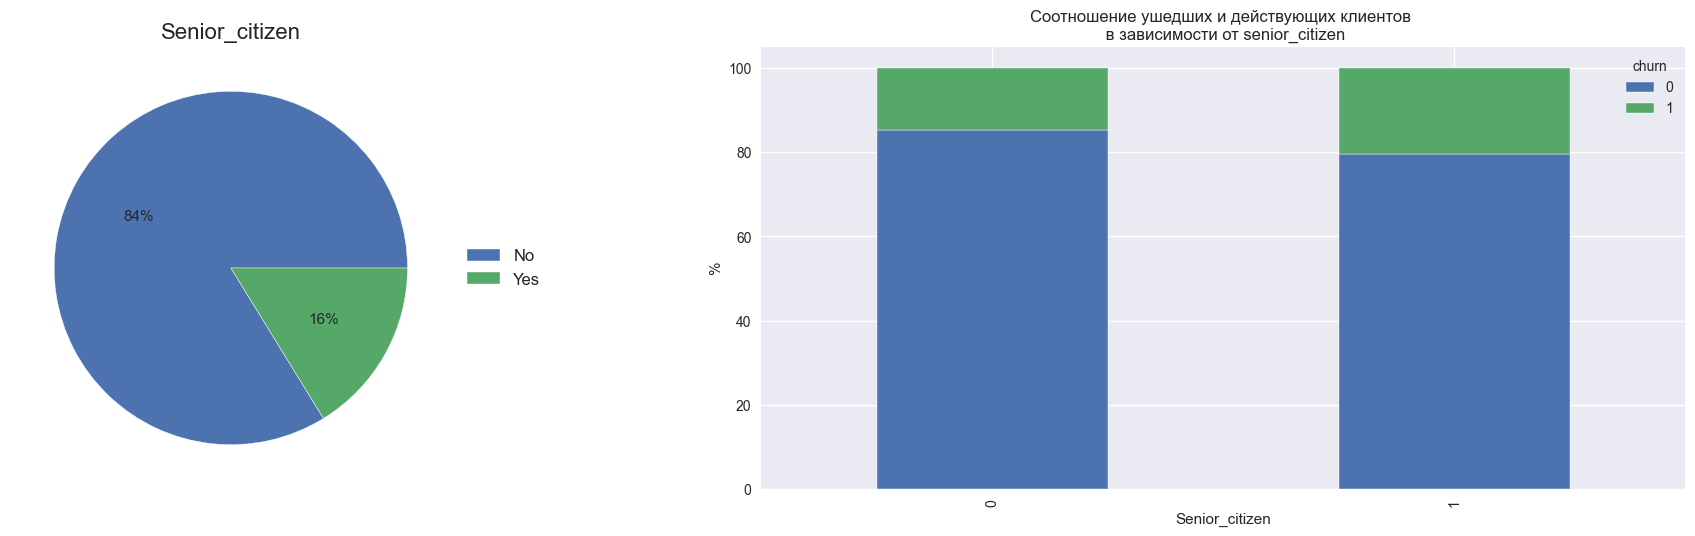

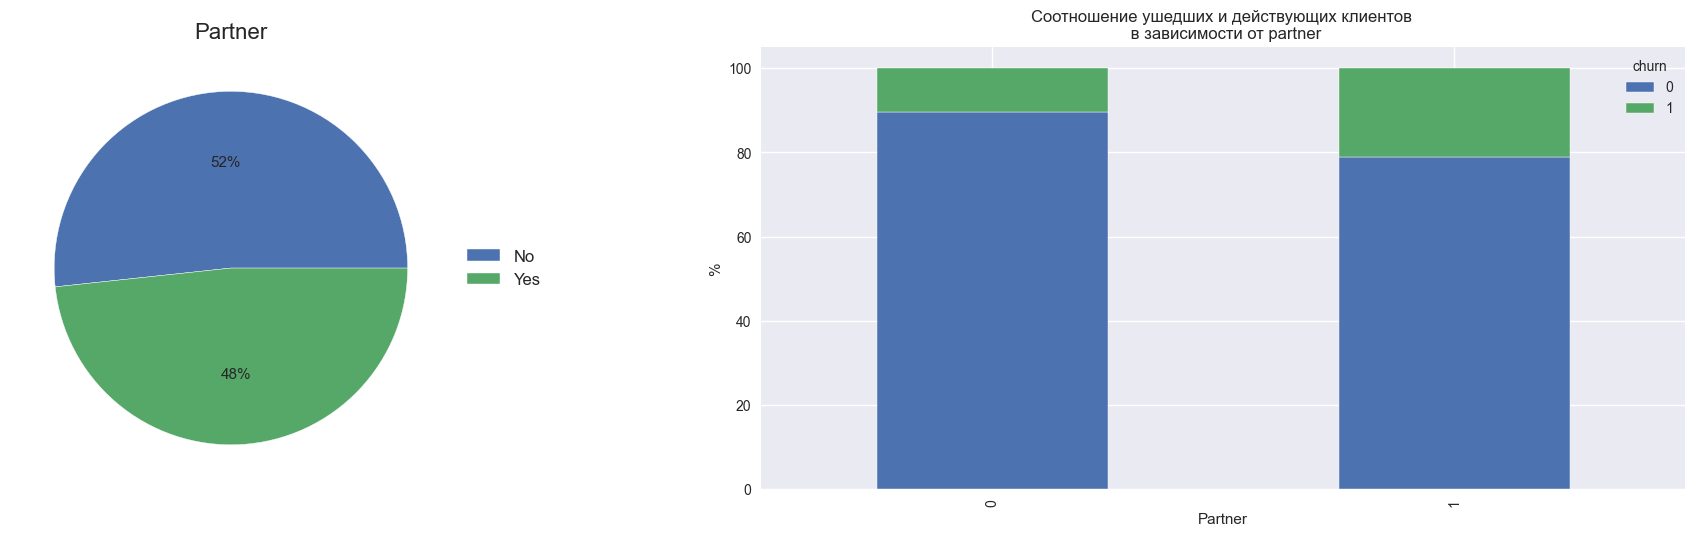

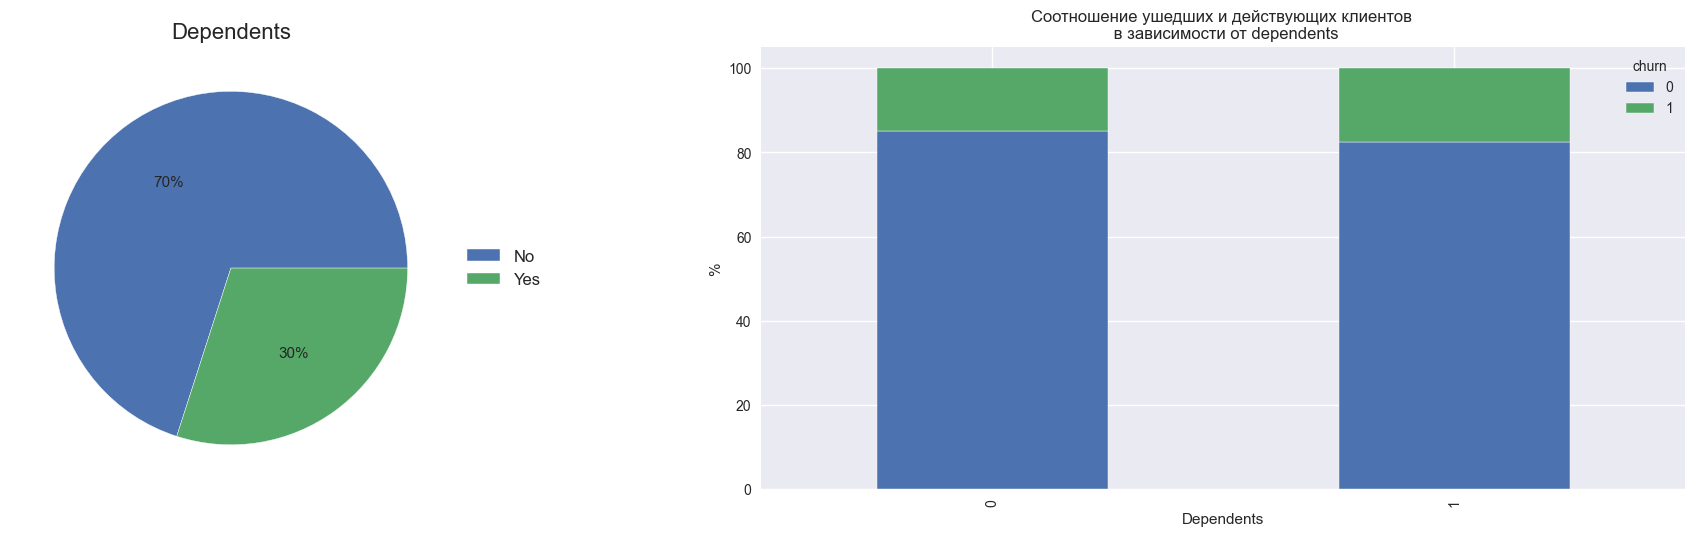

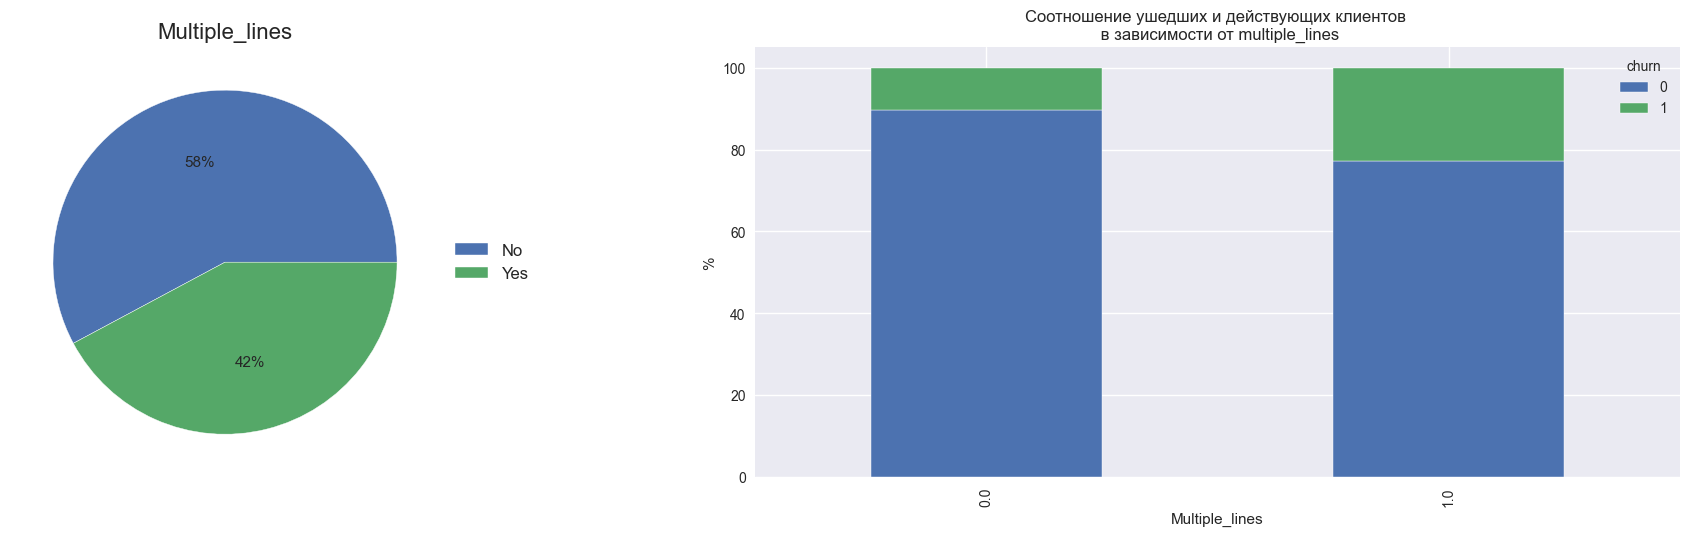

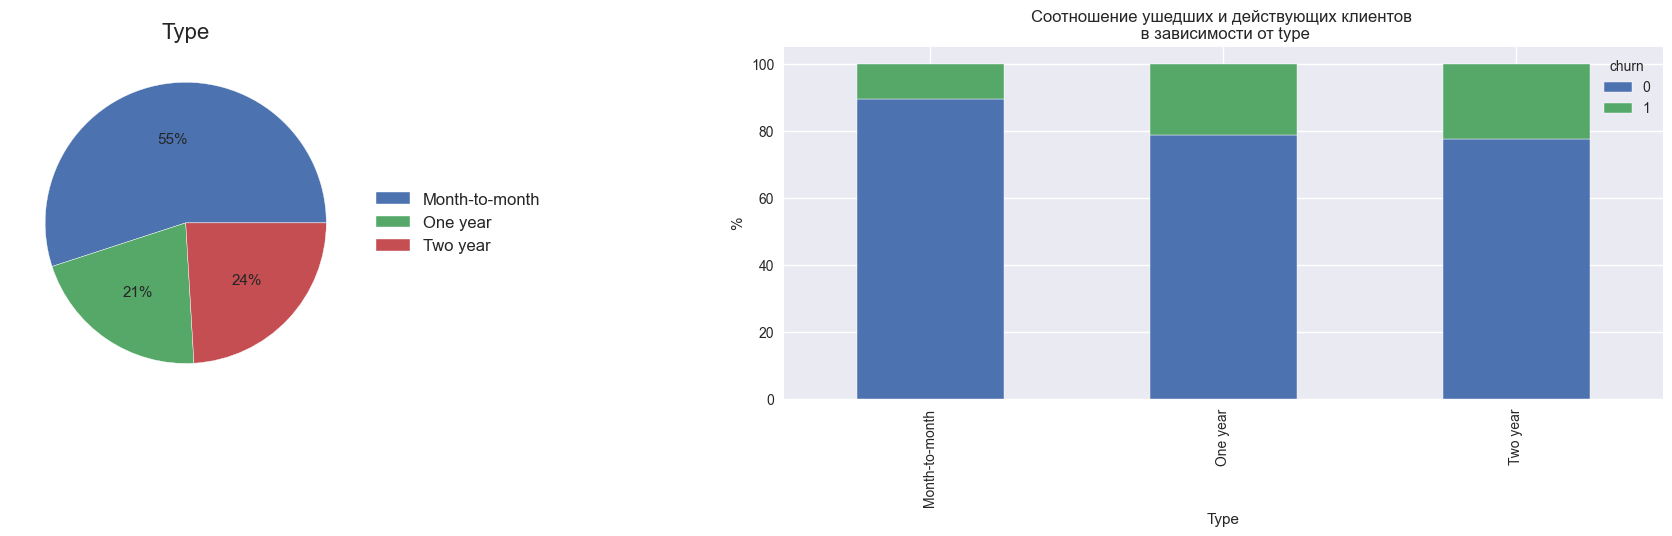

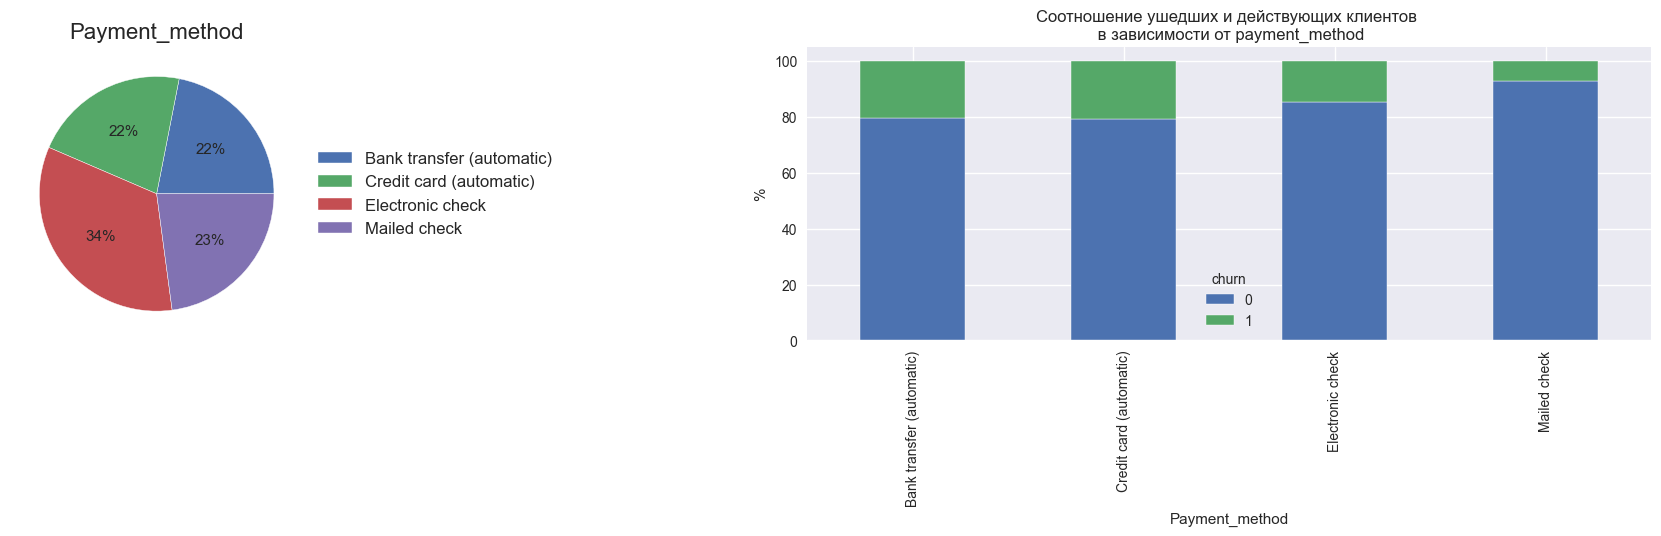

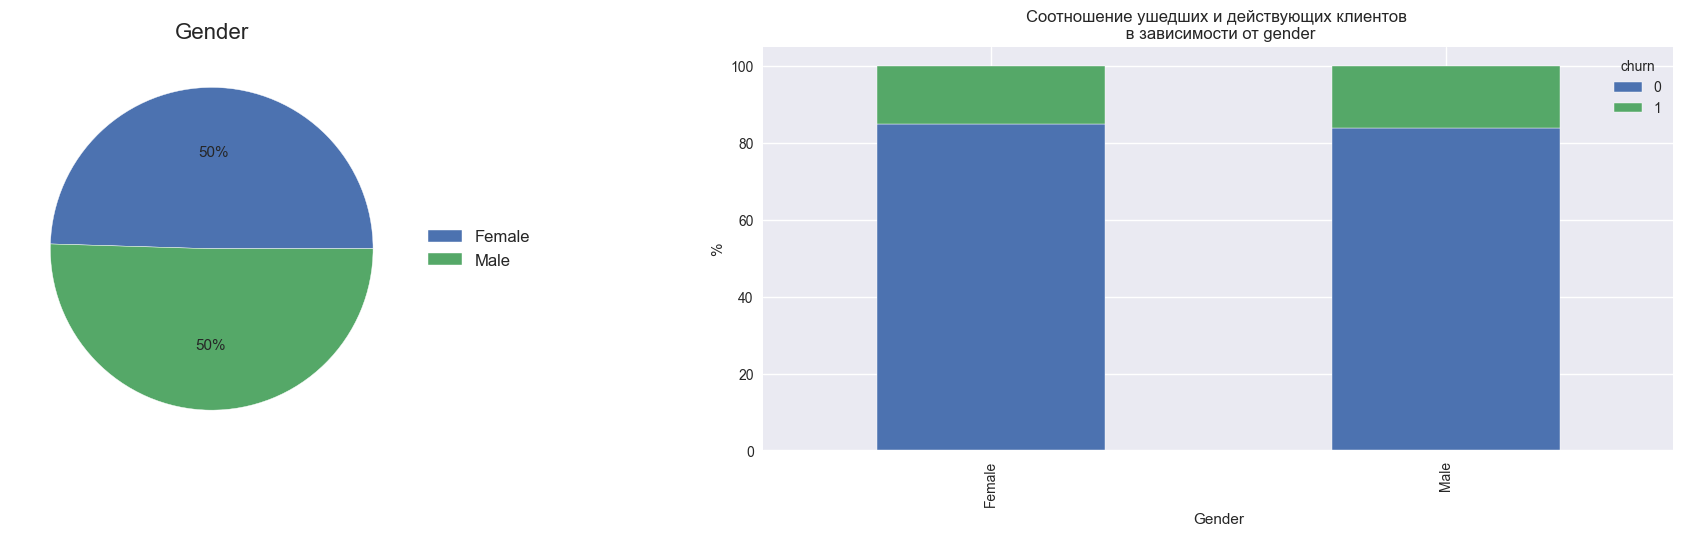

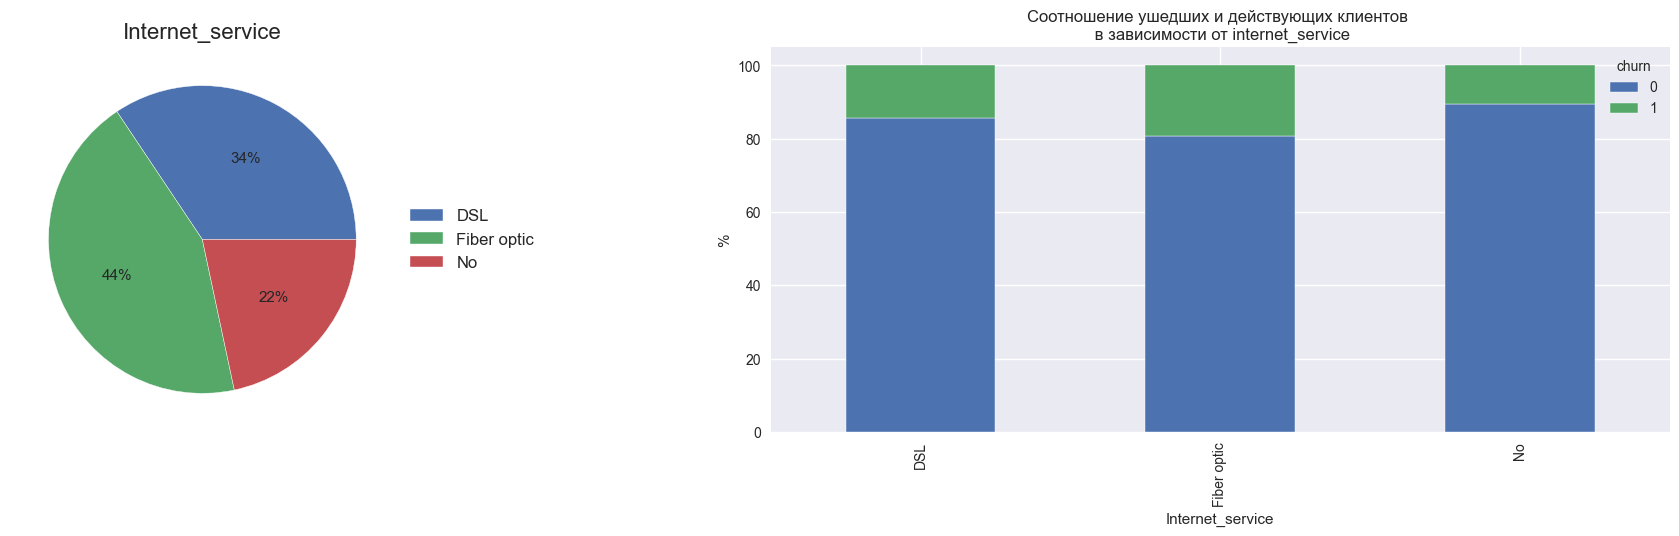

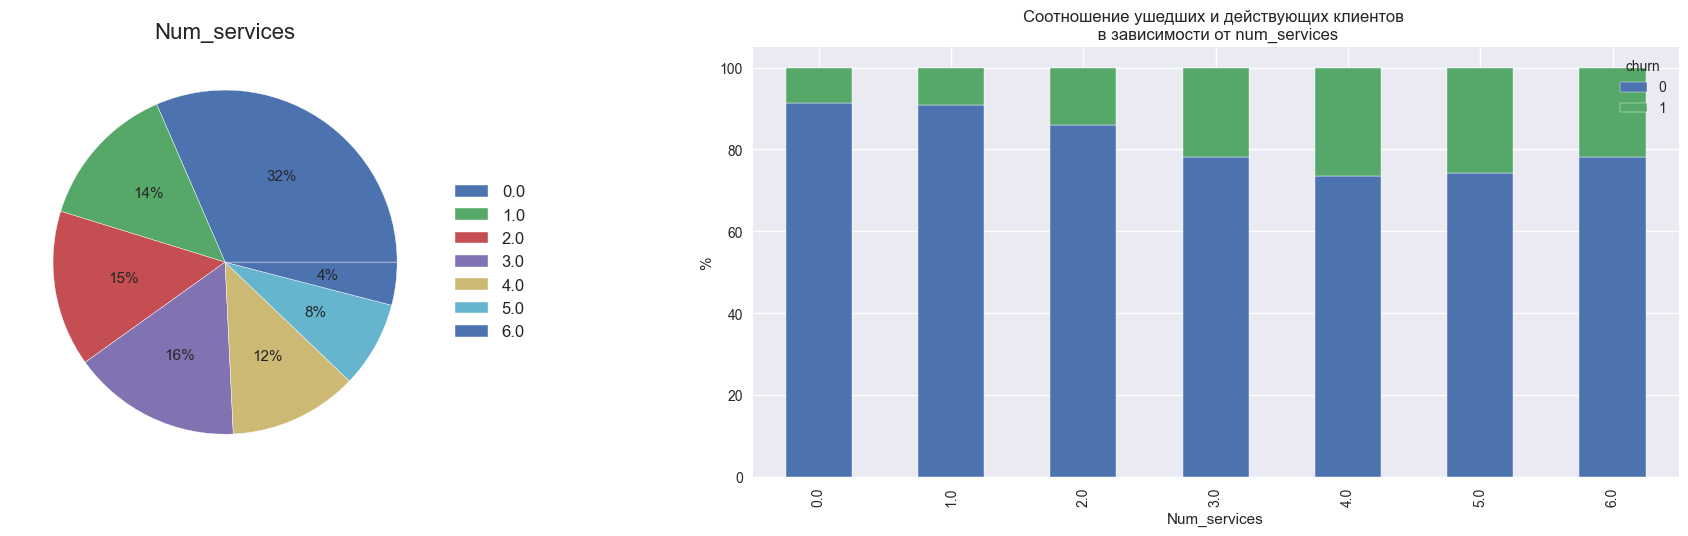

In [41]:
draw_categorical_chart(data
                             [['paperless_billing',
                               'senior_citizen',
                               'partner',
                               'dependents',
                               'multiple_lines',
                               'churn',
                               'customer_id',
                               'type',
                               'payment_method',
                               'gender',
                               'internet_service',
                               'num_services']])


 

<a id="28"></a>
### Промежуточный вывод

- В датасете действующих клиентов больше, чем ушедших по количеству примеров, т.е. имеем дело с несбалансированностью классов.


- У признака `gender` отсутствует корреляция как с таргетом, так и другими входными признаками, поэтому для обучения моделей его использовать не будем.
- Наблюдается мультиколлинеарность между входными признаками `internet_service` и `monthly_charges`. Это логично, сумма оплаты зависит от типа подключения. Можем исключить признак `internet_service` из обучения.
- Самая заметная связь у таргета с длительностью подписки и общими расходами. 
- Для обучения моделей также не планируется использовать признаки 
     - с датами начала и окончания договоров, т.к. ранее был введен новый производный признак "длительность подписки",  
     - бинарными признаками с услугами интернета, т.к. введен новый производный признак "количество услуг"
     - 'dependents',  'internet_service' в связи с низкой корреляцией с таргетом.
            
            
- Признак `monthly_charges`: распределение мультимодальное с явным пиком в начале около 20 у.е. Выбросов нет.

- Признак `total_charges`: распределение ассиметричное с явным пиком в начале. Есть выбросы - выше 7,5 тыс. у.е. - это самые лояльные абоненты с долгосрочными договорами.

- Признак `sub_duration`:
распределение мультимодальное с явным пиком в начале диаграммы. Выбросов нет.


- Для отточной группы клиентов характерны более высокие расходы для всех тарифных групп: например, для тарифа с ежегодной оплатой средние расходы составляют 89 у.е. для ушедших клиентов и 70 у.е. для оставшихся.
- Клиенты с договором более 4 лет менее склонны к оттоку.
- Заметен пик в ежемесячных расходах около 20 у.е., наиболее заметный для долгосрочных тарифов - похоже, что данные абоненты подключили долгосрочные тарифы по акции.

Для ушедших абонентов характерны более высокие расходы:
   - в среднем такие абоненты в месяц платят около 85 у.е., действующие абоненты - около 70 у.е.
   - общая сумма составляет 2,1 тыс. у.е., для действующих абонентов - около 1,2 тыс. у.е.
   
Длительность подписки также отличается:
- для ушедших абонентов - около 900 дней, для действующих - около 700.
   

Абоненты, чаще расторгающие договор:
- есть супруга или супруг
- подключение телефона к нескольким линиям одновременно.
- тип оплаты: раз в год-два
- тип подключения - Fiber optic
- количество подключенных интернет услуг больше 2.

<a id="16"></a>
## Подготовка данных

Выделим тренировочный и тестовый датасеты.

In [42]:
X = data.drop(['customer_id',
               'begin_date', 
               'end_date', 
               'churn', 
               'gender', 
               'online_security',
               'online_backup',
               'device_protection',
               'tech_support',
               'streaming_movies',
               'streaming_tv',
               'dependents',
               'internet_service'
              ], axis=1)
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, 
                                                                test_size=TEST_SIZE, 
                                                                stratify=y, 
                                                                random_state=RANDOM_STATE)
    
display(f'X_train: {X_train.shape}', 
        f'X_test: {X_test.shape}',
        f'y_train: {y_train.shape}', 
        f'y_test: {y_test.shape}' )


'X_train: (5282, 10)'

'X_test: (1761, 10)'

'y_train: (5282,)'

'y_test: (1761,)'

Создадим пайплайн для подготовки данных:
- масштабировании числовых признаков
- кодировании категориальных признаков.

In [43]:
class ToStringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.astype(str)

ohe_columns = ['type',
               'paperless_billing',
               'payment_method', 
               'multiple_lines',
               'senior_citizen',
               'partner']


num_columns = ['total_charges', 
               'monthly_charges', 
               'sub_duration',
               'num_services']


ohe_pipe = Pipeline([
    ('to_string', ToStringTransformer()), 
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', RobustScaler(), num_columns)], 
    remainder='passthrough'
)


<a id="17"></a>
## Обучение моделей машинного обучения

Создадим итоговый пайплайн для моделей логистической регрессии, случайного леса, бустинговых моделей LGBMC и CatBoost, и метода опорных векторов.

С помощью случайного подбора гиперпараметров выберем лучшую модель, метрика - ROC-AUC будет отображать способность модели отличать классы - клиент склонен к оттоку или нет.

In [44]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LogisticRegression(n_jobs= -1))
])


param_grid = [
    
        # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(n_jobs= -1)],
        'models__C': [0.001, 0.01, 0.1, 1],  
        'models__penalty': ['l1', 'l2'],      
        'models__solver': ['liblinear'],
        'preprocessor__num': [StandardScaler(),  RobustScaler(), 'passthrough']       
    },
     
    # словарь для модели RandomForestClassifier() 
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3,10),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(2,10),
        'models__n_estimators': [50, 100, 200],
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    
        # словарь для модели LGBMClassifier() 
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3,10),
        'models__learning_rate': [0.01, 0.03, 0.05],
        'models__num_leaves': [15, 20, 25, 30],
        'models__n_estimators': range(50, 500, 20),
        'models__reg_alpha': [0.0, 0.1, 0.5, 1.0],     
        'models__reg_lambda': [0.0, 0.1, 0.5, 1.0],
        'models__min_child_samples': [10, 15, 20, 30],
        'models__subsample': [0.6, 0.8, 1.0],  
        'models__colsample_bytree': [0.6, 0.8, 1.0],  
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    
        # словарь для модели CatBoostClassifier() 
    {
        'models': [CatBoostClassifier(loss_function='Logloss', silent=True, random_state=RANDOM_STATE)],
        'models__learning_rate': [0.01, 0.03],
        'models__iterations': range(50, 200, 20),
        'models__max_depth': range(3, 10),
        'models__l2_leaf_reg': [5, 10, 20],
        'models__bagging_temperature': [0.5, 1.0, 2.0],
        'models__subsample': [0.6, 0.8, 1.0],
        'preprocessor__num': [StandardScaler(),  RobustScaler(), 'passthrough']
    } ,
    
      #словарь для модели SVM() 
    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)], 
        'models__kernel': ['rbf', 'poly'],            
        'models__degree': range(2,5),
        'models__C': [0.01, 0.1, 1],
        'preprocessor__num': [StandardScaler(),  RobustScaler(), 'passthrough']
    }
]

rs = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=8,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=100
)

rs.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 721
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

RandomizedSearchCV(cv=8,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('to_string',
                                                                                                ToStringTransformer()),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'multiple_lines',
                                                                                'senior_citizen',
                                                                                'partner...
                                         'models__subsample': [0.6, 0.8, 1.0],
                                         'preprocessor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(probability=True,
                                                        random_state=100325)],
                                         'models__C': [0.01, 0.1, 1],
                                         'models__degree': range(2, 5),
                                         'models__kernel': ['rbf', 'poly'],
                                         'preprocessor__num': [StandardScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=100325, scoring='roc_auc')

<a id="18"></a>
## Выбор лучшей модели и ее тестирование

<a id="19"></a>
### Результат кросс-валидации

In [45]:
print('Лучшая модель и её параметры:\n\n', rs.best_params_, '\n\n')
print ('Метрика "ROC_AUC" лучшей модели на кросс-валидации:', rs.best_score_ , '\n\n'
       'Среднее время обучения на кросс-валидации: ',  
       pd.DataFrame(rs.cv_results_)
       .sort_values(by='rank_test_score')
       .head(1)['mean_fit_time']
       .values[0],  '\n\n'                         
        'Время предсказания: ', 
       pd.DataFrame(rs.cv_results_)
       .sort_values(by='rank_test_score')
       .head(1)['mean_score_time']
       .values[0], '\n\n')


Лучшая модель и её параметры:

 {'preprocessor__num': StandardScaler(), 'models__subsample': 1.0, 'models__reg_lambda': 0.1, 'models__reg_alpha': 0.0, 'models__num_leaves': 30, 'models__n_estimators': 450, 'models__min_child_samples': 10, 'models__max_depth': 6, 'models__learning_rate': 0.05, 'models__colsample_bytree': 0.8, 'models': LGBMClassifier(random_state=100325)} 


Метрика "ROC_AUC" лучшей модели на кросс-валидации: 0.9030446483280886 

Среднее время обучения на кросс-валидации:  18.33663383126259 

Время предсказания:  0.04432666301727295 




<a id="20"></a>
### Тестирование

In [46]:
y_pred_proba = rs.predict_proba(X_test)[:, 1]
pred = rs.predict(X_test)

print(f'Метрика "ROC_AUC" лучшей модели на тестовой выборке: {roc_auc_score(y_test, y_pred_proba) :.5f}', '\n\n')


Метрика "ROC_AUC" лучшей модели на тестовой выборке: 0.90298 




C:\Users\SAMSUNG\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\SAMSUNG\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [47]:
display('Рейтинг топ-5 моделей:',pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score')[['mean_fit_time',
'mean_score_time',
'params',
'split0_test_score',
'split1_test_score',
'split2_test_score',
'split3_test_score',
'split4_test_score',
'split5_test_score',
'split6_test_score',
'split7_test_score',
'mean_test_score']].head())



'Рейтинг топ-5 моделей:'

,mean_fit_time,mean_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score
15,18.336634,0.044327,"{'preprocessor__num': StandardScaler(), 'models__subsample': 1.0, 'models__reg_lambda': 0.1, 'models__reg_alpha': 0.0, 'models__num_leaves': 30, 'models__n_estimators': 450, 'models__min_child_samples': 10, 'models__max_depth': 6, 'models__learning_rate': 0.05, 'models__colsample_bytree': 0.8, 'models': LGBMClassifier(random_state=100325)}",0.903674,0.912132,0.898607,0.916247,0.870632,0.915811,0.881787,0.925468,0.903045
54,11.795332,0.039785,"{'preprocessor__num': StandardScaler(), 'models__subsample': 0.8, 'models__reg_lambda': 0.5, 'models__reg_alpha': 0.0, 'models__num_leaves': 15, 'models__n_estimators': 390, 'models__min_child_samples': 15, 'models__max_depth': 8, 'models__learning_rate': 0.05, 'models__colsample_bytree': 1.0, 'models': LGBMClassifier(random_state=100325)}",0.899738,0.907351,0.899479,0.912360,0.863433,0.917153,0.877900,0.918722,0.899517
3,9.783662,0.043134,"{'preprocessor__num': RobustScaler(), 'models__subsample': 0.8, 'models__reg_lambda': 0.0, 'models__reg_alpha': 0.0, 'models__num_leaves': 15, 'models__n_estimators': 330, 'models__min_child_samples': 15, 'models__max_depth': 8, 'models__learning_rate': 0.05, 'models__colsample_bytree': 0.8, 'models': LGBMClassifier(random_state=100325)}",0.903881,0.907178,0.889927,0.906817,0.867912,0.920430,0.872950,0.916247,0.898168
72,12.438375,0.039232,"{'preprocessor__num': StandardScaler(), 'models__subsample': 1.0, 'models__reg_lambda': 0.0, 'models__reg_alpha': 1.0, 'models__num_leaves': 30, 'models__n_estimators': 390, 'models__min_child_samples': 10, 'models__max_depth': 5, 'models__learning_rate': 0.05, 'models__colsample_bytree': 1.0, 'models': LGBMClassifier(random_state=100325)}",0.899306,0.910941,0.892942,0.901239,0.858238,0.920064,0.876044,0.921668,0.897555
47,23.875833,0.037683,"{'preprocessor__num': 'passthrough', 'models__subsample': 0.6, 'models__reg_lambda': 0.5, 'models__reg_alpha': 0.0, 'models__num_leaves': 30, 'models__n_estimators': 470, 'models__min_child_samples': 15, 'models__max_depth': 8, 'models__learning_rate': 0.05, 'models__colsample_bytree': 1.0, 'models': LGBMClassifier(random_state=100325)}",0.898650,0.911045,0.880602,0.907201,0.867738,0.914295,0.881857,0.916038,0.897178


<a id="21"></a>
### ROC-анализ

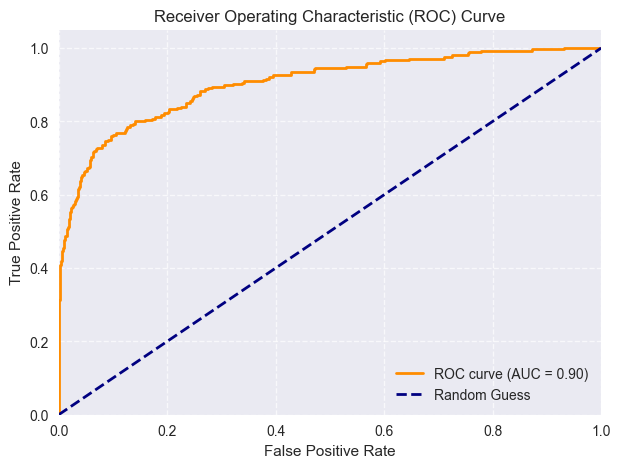

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Метрика ROC-AUC на кросс-валидации составила 0.9, на тесте - 0.9.

На графике видим, что кривая находится близко к верхнему левому углу и имеет большую площадь под кривой и значительно превышает случайные предсказания, отмеченные пунктирной линий, что говорит о хорошей производительности модели. 

<a id="22"></a>
### Анализ важности признаков

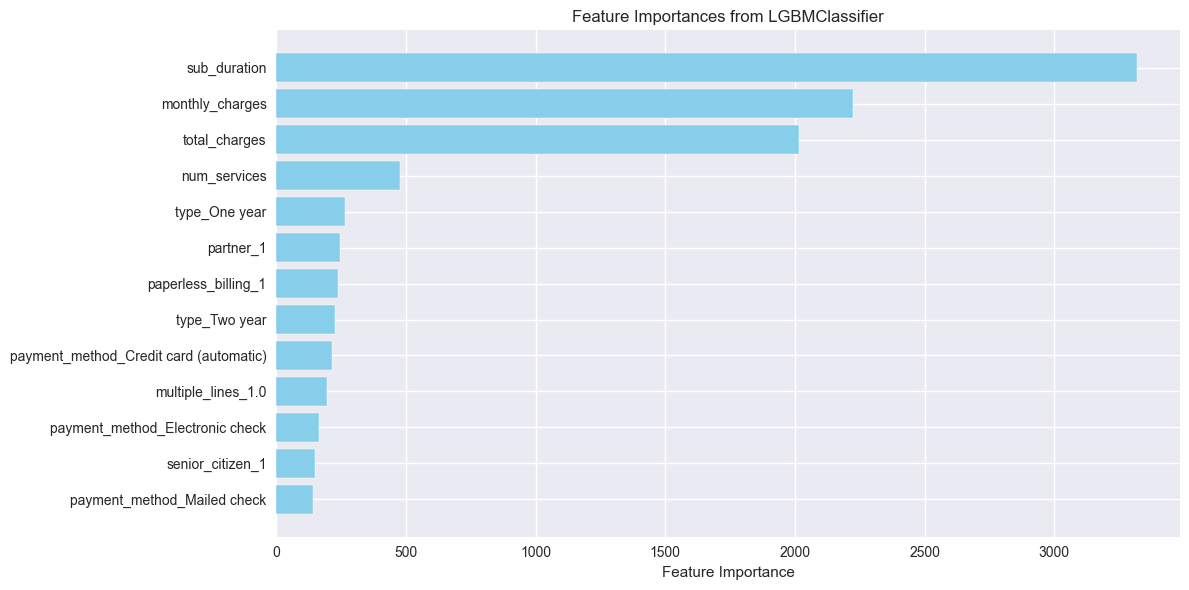

In [49]:
ohe_feature_names = (
    rs.best_estimator_.named_steps['preprocessor']
    .named_transformers_['ohe']
    .named_steps['ohe']
    .get_feature_names_out(ohe_columns)
).tolist()
num_feature_names = num_columns
all_feature_names = ohe_feature_names + num_feature_names

importances = rs.best_estimator_.named_steps['models'].feature_importances_
feature_importance_dict = dict(zip(all_feature_names, importances))

feature_importance_dict = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)}

sorted_features = list(feature_importance_dict.keys())
sorted_importances = list(feature_importance_dict.values())

plt.figure(figsize=(12, 6))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances from LGBMClassifier')
plt.gca().invert_yaxis()  
plt.tight_layout()

plt.show()

Наибольшее влияние оказывают 3 признака:
   - `длительность подписки` (с большим отрывом),
   - `расходы за месяц`,
   - `общие расходы абонента`.    

<a id="23"></a>
### Матрица ошибок и подбор порога

,Model,accuracy,recall,precision
0,Исходная,0.909710,0.523636,0.837209


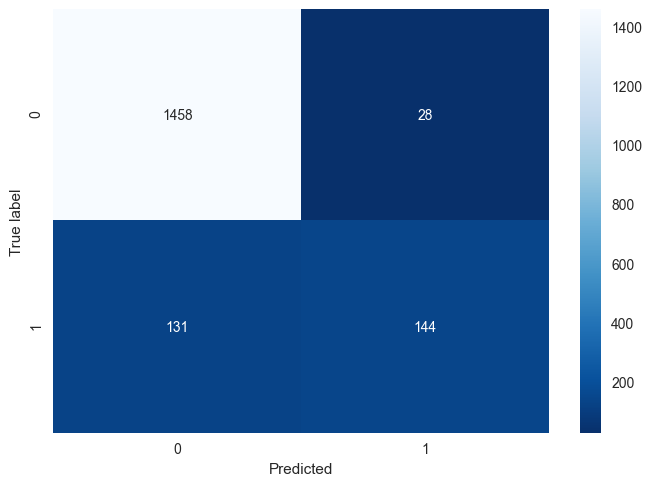

In [50]:
recall = recall_score(y_test, pred) 
precision = precision_score(y_test, pred) 
accuracy = accuracy_score(pred, y_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

df = pd.DataFrame({'Model': ['Исходная'], 
                   'accuracy': accuracy, 
                   'recall': recall, 
                   'precision': precision})

display(df.style.set_caption('Метрики качества обученной модели'))

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Метрика accuracy показывает, что модель в целом дает верные предсказания в 91 % случаев. Точность, с которой модель присвоила объектам класс 1, отражает метрика precision. Она равна 84 %. Обратная precision метрика recall показывает, что в 52 % случаев модель классификации присвоила класс 1 объектам верно.

Т.к. мы имеем дело с несбалансированностью классов, несмотря на то, что в целом модель предсказывает верно, однако в предсказании, попадет ли клиент в отток, ошибается почти в половине случаев. 

В случае предсказания расторгнет ли абонент договор, более критичной является ошибка второго рода - False Negative, когда модель ошибочно предсказывает, что клиент не попадет в отток. Т.к. компания понесет меньшие убытки на удержание клиента, чем на его потерю. Матрица ошибок показывает, что модель неверно предсказала класс в 131 случае.

Необходимо свести к минимуму ошибки второго рода, чтобы лучше отбирать тех клиентов, которые склонны к оттоку. 

Таким образом, необходимо поднять метрику recall, изменив порог принадлежности к классам. С ростом recall уменьшится значение precision.

In [51]:
def cost_false_negative(y_valid, y_pred_):
    if y_pred_ < y_valid:  
        return 1
    else:
        return 0 

def cost_false_positive(y_valid, y_pred_):
    if y_pred_ > y_valid: 
        return 1
    else:
        return 0

data = pd.DataFrame(zip(y_test, y_pred_proba),
                    columns=['y_valid', 'y_proba']).sort_values(by='y_proba')

thresholds = [round(i,2) for i in np.linspace(0, 0.5, num=12, endpoint=False)]

columns = []
fn_values = []  
fp_values = []  

for i in thresholds:
    column_name = 'y_pred_'+str(i)
    columns.append(column_name)
    
    data[column_name] = data['y_proba'].apply(lambda x: 1 if x >= i else 0)
    
    data['check_fn'] = data.apply(lambda x: cost_false_negative(x['y_valid'], x[column_name]), axis=1)
    fn_values.append(data['check_fn'].sum())
    
    data['check_fp'] = data.apply(lambda x: cost_false_positive(x['y_valid'], x[column_name]), axis=1)
    fp_values.append(data['check_fp'].sum())

costs = pd.DataFrame(zip(columns, fn_values, fp_values), 
                    columns=['Порог', 'False_Negative', 'False_Positive'])

display(costs)

,Порог,False_Negative,False_Positive
0,y_pred_0.0,0,1486
1,y_pred_0.04,18,660
2,y_pred_0.08,29,438
3,y_pred_0.12,46,305
4,y_pred_0.17,59,193
5,y_pred_0.21,69,141
6,y_pred_0.25,76,102
7,y_pred_0.29,87,86
8,y_pred_0.33,96,65
9,y_pred_0.38,107,54


Видим, что с уменьшением порога вероятности, ошибок второго рода становится меньше при одноврменном увеличении ошибок первого рода.
На отметке 0,29 количество ошибок двух классов примерно одинаковое.

Откалибруем модель с учетом данного порога.

C:\Users\SAMSUNG\anaconda3\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,accuracy,recall,precision
0,Исходная,0.909710,0.523636,0.837209
1,После калибровки,0.901760,0.683636,0.686131


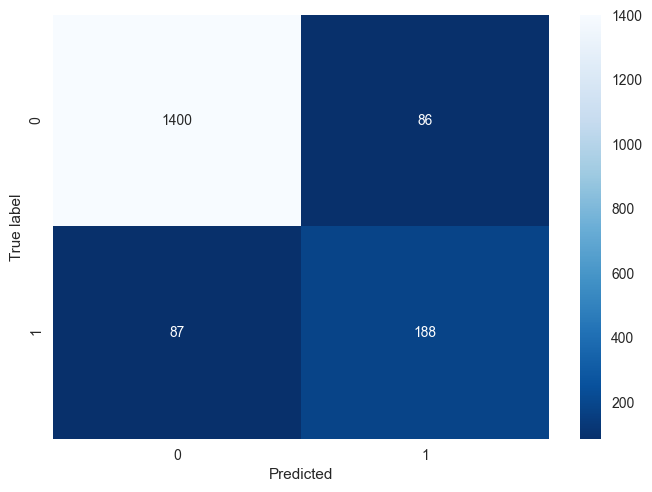

In [52]:
y_pred = rs.predict_proba(X_test)[:,1] >= 0.29

recall = recall_score(y_test, y_pred) 
precision = precision_score(y_test, y_pred) 
accuracy = accuracy_score(y_pred, y_test)

df = df.append({'Model': 'После калибровки', 
                'accuracy': accuracy, 
                'recall': recall, 
                'precision': precision}, ignore_index=True)

display(df.style.set_caption('Метрики качества обученной модели'))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r');
plt.ylabel('True label')
plt.xlabel('Predicted'); 

Из матрицы ошибок видим, что изменение порога принадлежности к классам уменьшило количество ошибок второго рода, теперь их 87, одновременно увеличилось количество ошибок первого рода до 86. 

Соотвественно метрика "Recall" увеличилась до 68 %, метрика "precision", напротив, стала ниже - 69%. 

Также снизилась метрика "accuracy" на 1 п.п., которая показывает. что в среденем модель дает правильные предсказания в 90 % случаев.

Дальнейшее занижение порога вероятности для уменьшения ошибок FN не считаю целесообразным, т.к. не следует подстраиваться под обучающую выборку.

<a id="24"></a>
## Общий вывод и рекомендации заказчику

В целях борьбы с оттоком клиентов, была обучена модель машинного обучения, которая прогнозирует, разорвёт ли абонент договор.

`Рекомендации для заказчика в целях сокращения оттока`:
- предоставить клиентам бесплатную пробную версию премиум-функций (например, облачное хранилище файлов для резервного копирования данных), чтобы побудить клиентов перейти на более дорогие тарифные планы, при которых вероятность отказа от услуг ниже.
- продемонстрировать наглядное сравнение экономии для долгосрочных тарифных планов, чтобы сделать их более привлекательными.
- улучшить пользовательский опыт путем адаптации с помощью обучающих программ, персональных рекомендаций и поддержки.
- для повышения вовлеченности пользователей проводить опросы, чтобы понять, почему клиенты отказываются от услуг, особенно если у них низкие тарифы или короткие сроки действия.

`Итоговая метрика ROC-AUC` составила 90 %, модель в целом дает верные предсказания в 90 % случаев, что отражает метрика accuracy. 

Т.к. распределение целевого признака несбалансированно, для лучшего предсказания клиентов, склонных к оттоку, модель была откалибрована путем сдвига порога вероятности.
Высокое значение метрик помогли достичь подбор различных гиперпараметров модели. 
Наибольшее влияние на обучение оказали 3 признака:
- длительность подписки (с большим отрывом),
- расходы за месяц,
- общие расходы абонента.

Лучшей моделью выбрана `модель градиентного бустинга LGBMClassifier` с гиперпараметрами:
- ридж-регуляризация 0.1 для предотвращения переобучения,
- максимальное количество листьев в одном дереве - 30 для ограничения сложности модели,
- 450 деревьев в ансамбле,
- не менее 10 примеров для каждого листа во избежание переобучения,
- максимальная глубина дерева - 6 уровней, для контроля сложности модели,
- скорость обучения 0.05,
- 0.8 - доля признаков, используемых для построения каждого дерева.

Для обучения модели были сгенерированы `дополнительные признаки`:
- целевой признак (клиент попал в отток).
- длительность подписки в днях .
- количество интернет услуг.

В связи с выводом производных признаков, отсутствием корреляции с таргетом или мультиколлинеарностью часть признаков не использовались для обучения: пол клиента,  тип подключения, даты начала и окончания договоров, бинарные признаки с различными услугами интернета, наличие детей.

`Предобработка данных` включала в т.ч: 
- для новых договоров, заключенных в феврале 2020 г. заполнение датой выгрузки из БД даты окончания контракта и 0 общих расходов, т.к. внесенная оплата еще не отображена в БД.
- Бинарные категориальные признаки конвертированы в '1/0'.
- В случае отсутствия абонента в таблицах об услугах интерент или телефонии, заполнение 0 пропусков, т.к. считаем, что абонент не подключал данные услуги.

`Исследовательский анализ` показал:

- Для отточной группы клиентов характерны более высокие расходы для всех тарифных групп: например, для тарифа с ежегодной оплатой средние расходы составляют 89 у.е. для ушедших клиентов и 70 у.е. для оставшихся.
- Клиенты с договором более 4 лет менее склонны к оттоку.
- Заметен пик в ежемесячных расходах около 20 у.е., наиболее заметный для долгосрочных тарифов - похоже, что данные абоненты подключили долгосрочные тарифы по акции.
- для ушедших абонентов длительность подписки составлят около 900 дней, для действующих - около 700.
   
Абоненты, чаще расторгающие договор:
- есть супруга или супруг
- подключение телефона к нескольким линиям одновременно.
- тип оплаты: раз в год-два
- тип подключения - Fiber optic
- количество подключенных интернет услуг больше 2.



